# Objective: fine-tuning DETR

-   This notebook can be found on my Github profile: https://github.com/woctezuma/finetune-detr
-   Official DETR repository: https://github.com/facebookresearch/detr
-   Discussion about fine-tuning in [a Github issue](https://github.com/facebookresearch/detr/issues/9).
-   A nice blog post about another approach (Mask R-CNN) and the balloon dataset (which we use in this notebook): [here](https://engineering.matterport.com/splash-of-color-instance-segmentation-with-mask-r-cnn-and-tensorflow-7c761e238b46).

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Define useful boilerplate functions

Adapted from:
-   https://colab.research.google.com/github/facebookresearch/detr/blob/colab/notebooks/detr_attention.ipynb

In [ ]:
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

torch.set_grad_enabled(False);

import os
proj_path = "/content/drive/My Drive/Main Task"
os.chdir(proj_path)

1.6.0+cu101 False


In [ ]:
import torchvision.transforms as T

# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

In [ ]:
def filter_bboxes_from_outputs(outputs, size,
                               threshold=0.7):
  
  # keep only predictions with confidence above threshold
  probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
  keep = probas.max(-1).values > threshold

  probas_to_keep = probas[keep]

  # convert boxes from [0; 1] to image scales
  bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], size)
  
  return probas_to_keep, bboxes_scaled

In [ ]:
def bb_intersection_over_union(boxA, boxB):
	# determine the (x, y)-coordinates of the intersection rectangle
	xA = max(boxA[0], boxB[0])
	yA = max(boxA[1], boxB[1])
	xB = min(boxA[2], boxB[2])
	yB = min(boxA[3], boxB[3])
	# compute the area of intersection rectangle
	interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
	# compute the area of both the prediction and ground-truth
	# rectangles
	boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
	boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
	# compute the intersection over union by taking the intersection
	# area and dividing it by the sum of prediction + ground-truth
	# areas - the interesection area
	iou = interArea / float(boxAArea + boxBArea - interArea)
	# return the intersection over union value
	return iou

In [ ]:
# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

## Load pre-trained weights

Load a check-point (urls can be found [here](https://github.com/facebookresearch/detr#model-zoo)), then remove the classification head.

In [ ]:
# Get pretrained weights
checkpoint = torch.hub.load_state_dict_from_url(
            url='https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth',
            map_location='cpu',
            check_hash=True)

# Remove class weights
del checkpoint["model"]["class_embed.weight"]
del checkpoint["model"]["class_embed.bias"]

# Save
os.chdir(os.path.join(proj_path,"content/detr"))
torch.save(checkpoint,
           'detr-r50_no-class-head.pth')

Downloading: "https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth" to /root/.cache/torch/hub/checkpoints/detr-r50-e632da11.pth


## Prepare the dataset for fine-tuning

We expect the directory structure to be the following:
```
path/to/coco/
├ annotations/  # JSON annotations
│  ├ annotations/custom_train.json
│  └ annotations/custom_val.json
├ train2017/    # training images
└ val2017/      # validation images
```

## Check the dataset after it was pre-processed for fine-tuning

To verify the data loading is correct, let's visualize the annotations of randomly selected samples in the training set:
-   Demo of COCO API: https://github.com/cocodataset/cocoapi/blob/master/PythonAPI/pycocoDemo.ipynb

In [ ]:
%matplotlib inline
import pycocotools.coco as coco
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (10.0, 8.0)
from PIL import Image

In [ ]:
dataDir=proj_path+'/content/data/DocBank/'
dataType='train'
annFile='{}annotations/train.json'.format(dataDir)

In [ ]:
# initialize COCO api for instance annotations
coco=COCO(annFile)

loading annotations into memory...
Done (t=6.62s)
creating index...
index created!


In [ ]:
# display COCO categories and supercategories
cats = coco.loadCats(coco.getCatIds())
nms=[cat['name'] for cat in cats]
print(nms)
nms1 = set([cat['supercategory'] for cat in cats])
print(nms1)

['abstract', 'author', 'caption', 'date', 'equation', 'figure', 'footer', 'formula', 'list', 'logo', 'natural_image', 'paragraph', 'reference', 'section', 'signature', 'table', 'title']
{'none'}


In [ ]:
# load and display image
catIds = coco.getCatIds(catNms=[])

for id in catIds:
  imgCount = len(coco.getImgIds(catIds=id))
  if imgCount > 0:
    print("id :",id,", name : ",nms[id],", image count : ",imgCount)

imgIds = coco.getImgIds(catIds=[4,11,13])
# will return images having all objects mentioned in the catIds list

#print(catIds)
print(len(imgIds))

id : 0 , name :  abstract , image count :  82
id : 1 , name :  author , image count :  67
id : 2 , name :  caption , image count :  239
id : 3 , name :  date , image count :  18
id : 4 , name :  equation , image count :  397
id : 5 , name :  figure , image count :  204
id : 6 , name :  footer , image count :  97
id : 8 , name :  list , image count :  124
id : 11 , name :  paragraph , image count :  997
id : 12 , name :  reference , image count :  90
id : 13 , name :  section , image count :  448
id : 15 , name :  table , image count :  36
id : 16 , name :  title , image count :  49
176


/content/drive/My Drive/Main Task/content/data/DocBank//train/1.tar_1401.0438.gz_eta_aut_final_3_ori.jpg


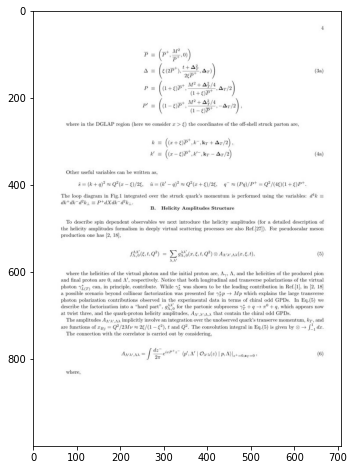

In [ ]:
img_id = imgIds[np.random.randint(0,len(imgIds))]
#print(img_id)

img = coco.loadImgs(img_id)[0]

img_name = '%s/%s/%s'%(dataDir,dataType,img['file_name'])
print(img_name)

I = io.imread(img_name)
plt.imshow(I)

In [ ]:
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds)
anns = coco.loadAnns(annIds)
print(annIds)
_ = [print(i) for i in anns]

[206977, 206978, 206979, 206980, 206981, 206982, 206983, 206984, 206985, 206986, 206987, 206988, 206989, 206990, 206991, 206992, 206993, 206994, 206995, 206996, 206997, 206998, 206999, 207000, 207001, 207002, 207003, 207004, 207005, 207006, 207007, 207008, 207009, 207010, 207011, 207012, 207013, 207014, 207015, 207016, 207017, 207018, 207019, 207020, 207021, 207022, 207023, 207024, 207025, 207026, 207027, 207028, 207029, 207030, 207031, 207032, 207033, 207034, 207035, 207036, 207037, 207038, 207039, 207040, 207041, 207042, 207043, 207044, 207045, 207046, 207047, 207048, 207049, 207050, 207051, 207052, 207053, 207054, 207055, 207056, 207057, 207058, 207059, 207060, 207061, 207062, 207063, 207064, 207065, 207066, 207067, 207068, 207069, 207070, 207071, 207072, 207073, 207074, 207075, 207076, 207077, 207078, 207079, 207080, 207081, 207082, 207083, 207084, 207085, 207086, 207087, 207088, 207089, 207090, 207091, 207092, 207093, 207094, 207095, 207096, 207097, 207098, 207099, 207100, 207101,

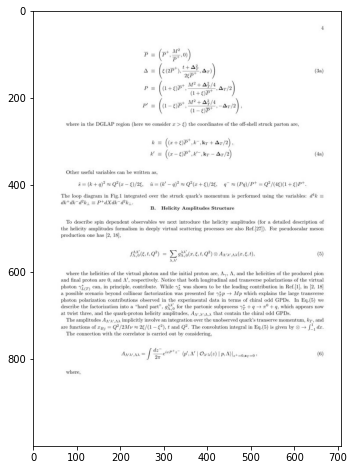

In [ ]:
# load and display instance annotations
plt.imshow(I)
coco.showAnns(anns, draw_bbox=False)

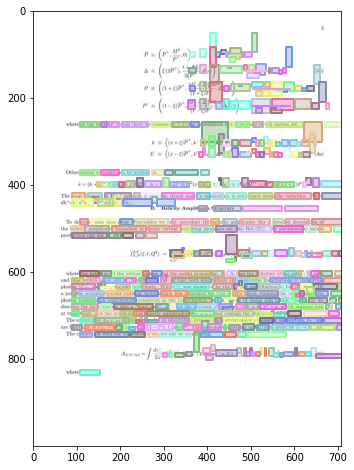

In [ ]:
plt.imshow(I)
coco.showAnns(anns, draw_bbox=True)

## Fine-tuning

-   Instructions appear in [a Github Gist](https://gist.github.com/mlk1337/651297e28199b4bb7907fc413c49f58f).

NB: There is a `--frozen_weights` argument. However,
i) I have yet to figure out how it is used,
ii) it is of no use for box detection. Indeed, "frozen training is meant for segmentation only" (as mentioned at this [line](https://github.com/facebookresearch/detr/blob/f4cdc542de34de771da8b9189742e5465f5220cd/main.py#L110) of the source-code).

## Boilerplate variables
Caveat: the parameter name num_classes is misleading. It is actually the ID which DETR will reserve for its own no_object class.

It should be set to one plus the highest class ID in your dataset.

For instance, if you have one class (balloon):

-   if you used the index n°0 for this class, then max_id = 0 and num_classes = max_id+1 = 1
-   if you used the index n°1 for this class, then max_id = 1 and num_classes = max_id+1 = 2

Reference: https://github.com/facebookresearch/detr/issues/108#issuecomment-650269223

In [ ]:
# Fine-tuned classes
finetuned_classes = [
                     'abstract', 'author', 'caption', 'date', 'equation', 'figure', 'footer', 'formula', 'list', 'logo', 'natural_image', 'paragraph', 'reference', 'section', 'signature', 'table', 'title'
]

num_classes = len(finetuned_classes)
print(num_classes)

17


In [ ]:
os.chdir(os.path.join(proj_path,"content/detr"))
print(os.getcwd())

#resume "/content/drive/My Drive/Main Task/content/detr/outputs/checkpoint.pth" \
#resume "/content/drive/My Drive/Main Task/content/detr/detr-r50_no-class-head.pth" \

/content/drive/My Drive/Main Task/content/detr


In [ ]:
!python main.py \
  --dataset_file "custom" \
  --coco_path "/content/drive/My Drive/Main Task/content/data/DocBank" \
  --output_dir "outputs" \
  --resume "/content/drive/My Drive/Main Task/content/detr/outputs/checkpoint.pth" \
  --num_classes $num_classes \
  --epochs 20 \
  --device "cuda"

Not using distributed mode
git:
  sha: 6ecf58fe5e8eb503cb3be015983756789a9964f5, status: has uncommited changes, branch: finetune

Namespace(aux_loss=True, backbone='resnet50', batch_size=2, bbox_loss_coef=5, clip_max_norm=0.1, coco_panoptic_path=None, coco_path='/content/drive/My Drive/Main Task/content/data/DocBank', dataset_file='custom', dec_layers=6, device='cuda', dice_loss_coef=1, dilation=False, dim_feedforward=2048, dist_url='env://', distributed=False, dropout=0.1, enc_layers=6, eos_coef=0.1, epochs=20, eval=False, frozen_weights=None, giou_loss_coef=2, hidden_dim=256, lr=0.0001, lr_backbone=1e-05, lr_drop=200, mask_loss_coef=1, masks=False, nheads=8, num_classes=17, num_queries=100, num_workers=2, output_dir='outputs', position_embedding='sine', pre_norm=False, remove_difficult=False, resume='/content/drive/My Drive/Main Task/content/detr/outputs/checkpoint.pth', seed=42, set_cost_bbox=5, set_cost_class=1, set_cost_giou=2, start_epoch=0, weight_decay=0.0001, world_size=1)
Do

## Check the results

### Monitoring of training

Reference: https://github.com/lessw2020/Thunder-Detr/blob/master/View_your_training_results.ipynb

In [ ]:
from util.plot_utils import plot_logs

from pathlib import Path

log_directory = [Path('outputs/')]

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


  As mentioned in the code of [`plot_logs`](https://github.com/facebookresearch/detr/blob/5e66b4cd15b2b182da347103dd16578d28b49d69/util/plot_utils.py#L13):
-   solid lines are training results,
-   dashed lines are validation results.

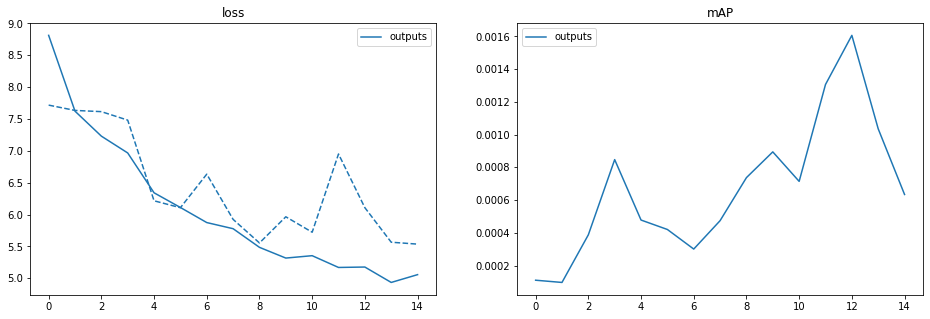

In [ ]:
fields_of_interest = (
    'loss',
    'mAP',
    )

plot_logs(log_directory,
          fields_of_interest)

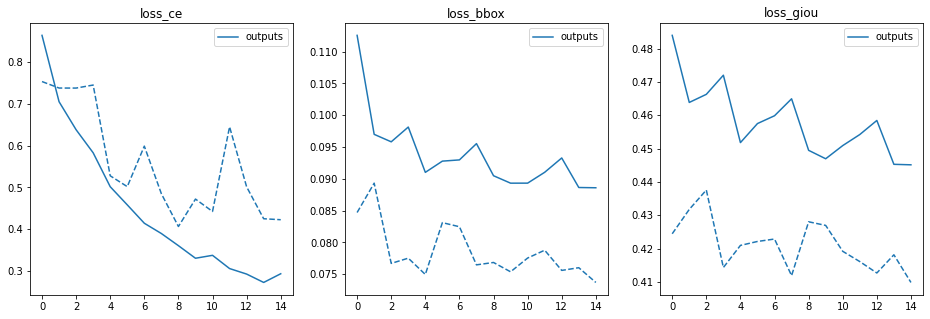

In [ ]:
fields_of_interest = (
    'loss_ce',
    'loss_bbox',
    'loss_giou',
    )

plot_logs(log_directory,
          fields_of_interest)

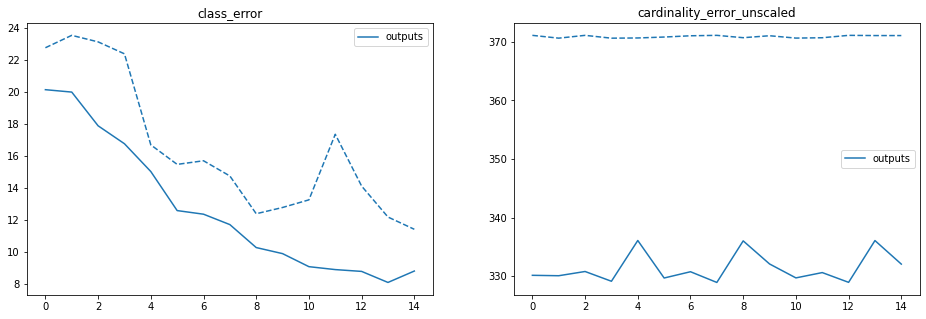

In [ ]:
fields_of_interest = (
    'class_error',
    'cardinality_error_unscaled',
    )

plot_logs(log_directory,
          fields_of_interest)   

### Load the fine-tuned model

- Explanation: https://github.com/facebookresearch/detr/issues/9#issuecomment-636391562

In [ ]:
model = torch.hub.load('facebookresearch/detr',
                       'detr_resnet50',
                       pretrained=False,
                       num_classes=num_classes)

checkpoint = torch.load('outputs/checkpoint.pth',
                        map_location='cpu')

model.load_state_dict(checkpoint['model'],
                      strict=False)

model.eval();

Downloading: "https://github.com/facebookresearch/detr/archive/master.zip" to /root/.cache/torch/hub/master.zip
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


### Boilerplate functions to display fine-tuned results

In [ ]:
def plot_finetuned_results(pil_img, prob=None, boxes=None):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    if prob is not None and boxes is not None:
      for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
          ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                    fill=False, color=c, linewidth=3))
          cl = p.argmax()
          text = f'{finetuned_classes[cl]}: {p[cl]:0.2f}'
          ax.text(xmin, ymin, text, fontsize=15,
                  bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

In [ ]:
def run_worflow(my_image, my_model):
  # mean-std normalize the input image (batch-size: 1)
  img = transform(my_image).unsqueeze(0)

  # propagate through the model
  outputs = my_model(img)

  for threshold in [0.9, 0.5, 0.0]:
    
    probas_to_keep, bboxes_scaled = filter_bboxes_from_outputs(outputs, my_image.size,
                                                               threshold=threshold)

    plot_finetuned_results(my_image,
                           probas_to_keep, 
                           bboxes_scaled)


### With a training image

/content/drive/My Drive/Main Task


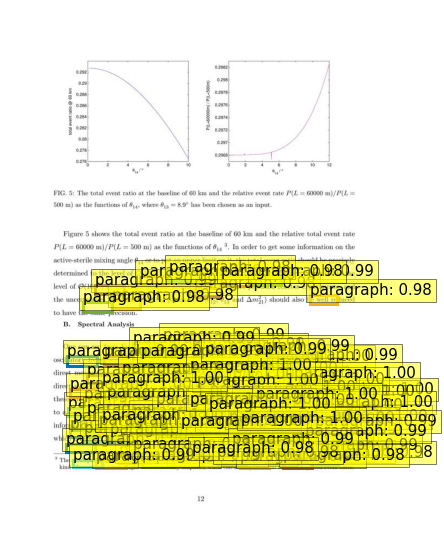

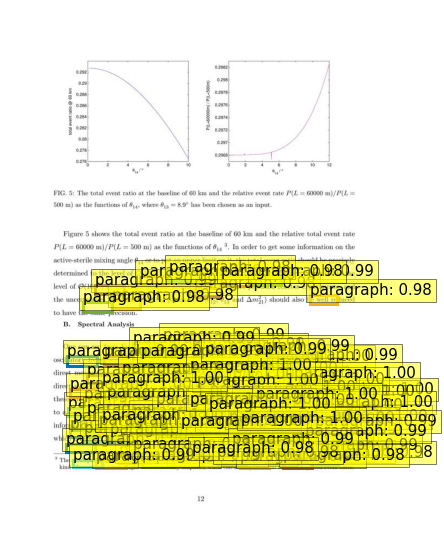

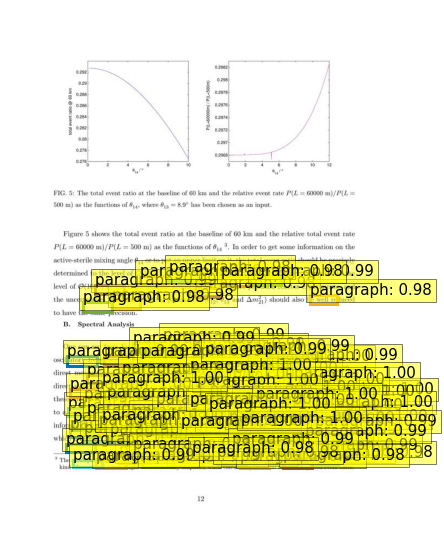

In [ ]:
train_path = proj_path+'/content/data/DocBank/train/'
imgs = os.listdir(train_path)
rand_img = imgs[np.random.randint(0,len(imgs))]

os.chdir(proj_path)
print(os.getcwd())
img_name = proj_path + '/content/data/DocBank/train/' + rand_img

im = Image.open(img_name)

run_worflow(im,
            model)

### With a validation image

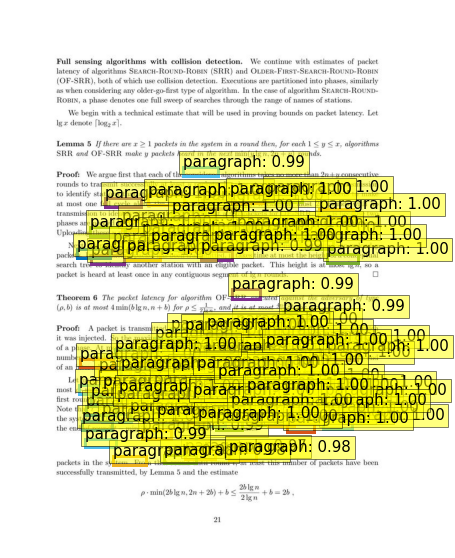

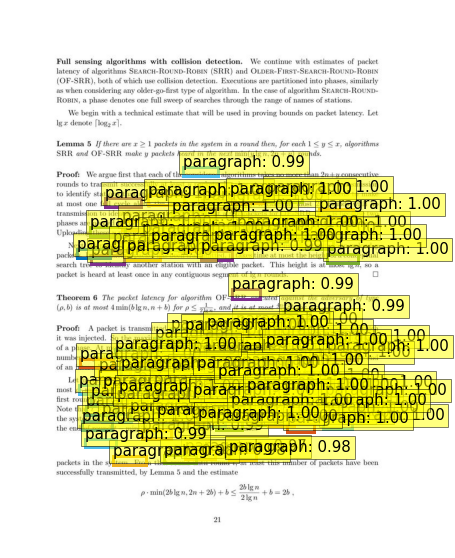

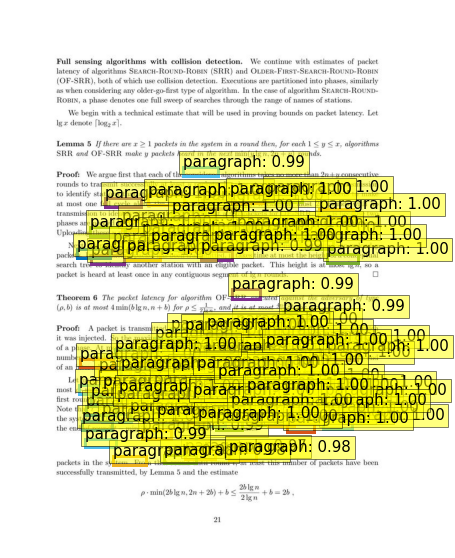

In [ ]:
val_path = proj_path+'/content/data/DocBank/val/'
imgs = os.listdir(val_path)
rand_img = imgs[np.random.randint(0,len(imgs))]

img_name = proj_path + '/content/data/DocBank/val/' + rand_img
im = Image.open(img_name)

run_worflow(im,
            model)

## Evaluate on all images

In [ ]:
from tqdm.notebook import tqdm
import json
import pandas as pd


dataDir=proj_path+'/content/data/DocBank/'
dataType='train'
annFile='{}annotations/train.json'.format(dataDir)

output_annotation_file = proj_path+'/content/detr/outputs/predictions.json'
imgsDir = dataDir + '/' + dataType

In [ ]:
# initialize COCO api for instance annotations
coco=COCO(annFile)

imgIds = coco.getImgIds()

loading annotations into memory...
Done (t=6.06s)
creating index...
index created!


In [ ]:
# display COCO categories and supercategories
cats = coco.loadCats(coco.getCatIds())
nms=[cat['name'] for cat in cats]
print(nms)
nms1 = set([cat['supercategory'] for cat in cats])
print(nms1)

['abstract', 'author', 'caption', 'date', 'equation', 'figure', 'footer', 'formula', 'list', 'logo', 'natural_image', 'paragraph', 'reference', 'section', 'signature', 'table', 'title']
{'none'}


## Save the outputs to a json file

In [ ]:
img_data = []

for imgId in tqdm(imgIds):

  img = coco.loadImgs(imgId)[0]
  img_name = '%s/%s/%s'%(dataDir,dataType,img['file_name'])
  #print(img_name)

  im = Image.open(img_name)
  im1 = transform(im).unsqueeze(0)

  # propagate through the model
  outputs = model(im1)
  
  annotations_tmp = {}
  for logits,boxes in zip(outputs["pred_logits"],outputs["pred_boxes"]):
    annotations_tmp['image_id'] = imgId
    annotations_tmp['image_size'] = im.size
    annotations_tmp['pred_logits'] = logits.tolist()
    annotations_tmp['pred_boxes'] = boxes.tolist()
    img_data.append(annotations_tmp)

#save the outputs to a json file
outfile =  open(output_annotation_file, 'w')
json_str = json.dumps(img_data, indent=4)
outfile.write(json_str)
outfile.close()      

In [ ]:
imgsDir = dataDir + '/' + dataType
imgIds = coco.getImgIds();
bb_threshold = 0.85
iou_threshold = 0.5

results = []
for i in range(num_classes):
  results.append({'class':nms[i], 'rel':0, 'ret':0, 'rel_ret':0, 'prec':0, 'rec':0, 'F1':0})

#load the outputs from the json file to a dictionary
with open(output_annotation_file) as json_file: 
    img_data = json.load(json_file)

for imgId in tqdm(imgIds):
  
  img = coco.loadImgs(imgId)[0]
  img_name = '%s/%s/%s'%(dataDir,dataType,img['file_name'])
  #print(img_name)

  annIds = coco.getAnnIds(imgIds=img['id'])
  anns = coco.loadAnns(annIds)
  #_ = [print(ann) for ann in anns]
  #I = io.imread(img_name)
  #plt.imshow(I)
  #coco.showAnns(anns, draw_bbox=True)

  outputs = {}
  outputs["pred_logits"] = torch.FloatTensor([img_data[imgId]["pred_logits"]])
  outputs["pred_boxes"] =  torch.FloatTensor([img_data[imgId]["pred_boxes"]])

  prob, boxes = filter_bboxes_from_outputs(outputs, img_data[imgId]['image_size'], threshold=bb_threshold)
  #print(prob, boxes)
  #plot_finetuned_results(I, prob, boxes)


  for ann in anns:
    bb1 = list(ann['bbox'])
    cat1 = ann['category_id']
    results[cat1]['rel'] += 1

    #add del x, del y to x1, y1 to get x2, y2
    bb1[2] += bb1[0]; bb1[3] += bb1[1]
    for p, bb2 in zip(prob, boxes.tolist()):
      cat2 = int(p.argmax())
      if bb_intersection_over_union(bb1,bb2) >= iou_threshold and cat1==cat2:
        results[cat1]['rel_ret'] += 1
        break

  for p in prob:
    cat2 = int(p.argmax())
    results[cat2]['ret'] += 1

for cat in results:
  if cat['rel_ret'] != 0:
    cat['prec'] = cat['rel_ret'] / cat['ret']
    cat['rec'] = cat['rel_ret'] / cat['rel']
    cat['F1'] = 2 * (cat['prec']*cat['rec'])/((cat['prec']+cat['rec']))

df = pd.DataFrame(results)
df = df[(df.rel!=0) | (df.ret!=0) | (df.rel_ret!=0)]
print(df)
print("\nMean")
print(df[["prec", "rec", "F1"]].mean())


        class     rel    ret  rel_ret      prec       rec        F1
0    abstract   10153    923       72  0.078007  0.007092  0.013001
1      author    2010      0        0  0.000000  0.000000  0.000000
2     caption   16388   2923      123  0.042080  0.007505  0.012739
3        date      69      0        0  0.000000  0.000000  0.000000
4    equation   35806   1017       11  0.010816  0.000307  0.000597
5      figure    1565      0        0  0.000000  0.000000  0.000000
6      footer    3709      0        0  0.000000  0.000000  0.000000
8        list   15535    109        1  0.009174  0.000064  0.000128
11  paragraph  475728  80505     5597  0.069524  0.011765  0.020125
12  reference   23299   5365      318  0.059273  0.013649  0.022188
13    section    3007      0        0  0.000000  0.000000  0.000000
15      table    5464    473        5  0.010571  0.000915  0.001684
16      title     458      0        0  0.000000  0.000000  0.000000

Mean
prec    0.021496
rec     0.003177
F1     